In [103]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [67]:
# Load data
OE_detailed = pd.read_parquet(Path("../data/processed/oe_detailed.parquet"))
OE_Activity_prepped = pd.read_parquet(Path("../data/processed/oe_activity_prepped.parquet"))
OE_joined = pd.read_parquet(Path("../data/processed/oe_joined.parquet"))    
product_pick_times = pd.read_csv(Path("../data/processed/product_pick_times.csv"))

In [92]:
display(OE_detailed.head(3))

,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Prev_Timestamp,Prev_LocationID,...,Prev_Bay,Prev_Level,Prev_Slot,Aisle2,Bay2,Prev_Aisle2,Prev_Bay2,LocKey,PrevLocKey,Distance
0,PickPut,64,20,7955278,3250,1,2025-11-10 12:23:59.540,34343,NaT,<NA>,...,<NA>,<NA>,<NA>,42,12,<NA>,<NA>,42|12|||,<NA>|<NA>|||,NaN
1,PickPut,64,20,7955281,43178,1,2025-11-10 12:26:23.993,14453,2025-11-10 12:23:59.540,34343,...,12,6,7,34,26,42,12,34|26|||,42|12|||,220.0
2,PickPut,64,20,7955279,5842,1,2025-11-10 12:28:31.110,23294,2025-11-10 12:26:23.993,14453,...,26,6,1,42,05,34,26,42|05|||,34|26|||,514.0


In [68]:
# Compute for how many productID we have a row in product_pick_times and percentage of total products
num_products_with_pick_time = product_pick_times.shape[0]
total_products = OE_Activity_prepped["ProductID"].nunique()
percentage_products_with_pick_time = (num_products_with_pick_time / total_products) * 100 if total_products > 0 else 0
print(f"Number of ProductIDs with computed pick times: {num_products_with_pick_time}")
print(f"Percentage of ProductIDs with computed pick times: {percentage_products_with_pick_time:.2f}%")

# Compute for how many productID we have n_pairs>1 and percentage of total products
num_products_with_multiple_pairs = (product_pick_times["n_pairs"] > 1).sum()
print(f"Number of ProductIDs with more than 1 pair: {num_products_with_multiple_pairs}")
percentage_products_with_multiple_pairs = (num_products_with_multiple_pairs / total_products) * 100 if total_products > 0 else 0
print(f"Percentage of ProductIDs with more than 1 pair: {percentage_products_with_multiple_pairs:.2f}%")

Number of ProductIDs with computed pick times: 2187
Percentage of ProductIDs with computed pick times: 28.44%
Number of ProductIDs with more than 1 pair: 1423
Percentage of ProductIDs with more than 1 pair: 18.50%


In [69]:
# Percentage of productIDs with avg_pick_time_sec < 1s, < 5s, and > 10s
num_products_fast_pick = (product_pick_times["avg_pick_time_sec"] < 1).sum()
num_products_moderate_pick = ((product_pick_times["avg_pick_time_sec"] >= 1) & (product_pick_times["avg_pick_time_sec"] < 10)).sum()
num_products_slow_pick = (product_pick_times["avg_pick_time_sec"] > 10).sum()
print(f"Number of ProductIDs with avg_pick_time_sec < 1s: {num_products_fast_pick} ({(num_products_fast_pick / num_products_with_pick_time) * 100:.2f}%)")
print(f"Number of ProductIDs with 1s <= avg_pick_time_sec < 10s: {num_products_moderate_pick} ({(num_products_moderate_pick / num_products_with_pick_time) * 100:.2f}%)")
print(f"Number of ProductIDs with avg_pick_time_sec > 10s: {num_products_slow_pick} ({(num_products_slow_pick / num_products_with_pick_time) * 100:.2f}%)")

Number of ProductIDs with avg_pick_time_sec < 1s: 915 (41.84%)
Number of ProductIDs with 1s <= avg_pick_time_sec < 10s: 667 (30.50%)
Number of ProductIDs with avg_pick_time_sec > 10s: 605 (27.66%)


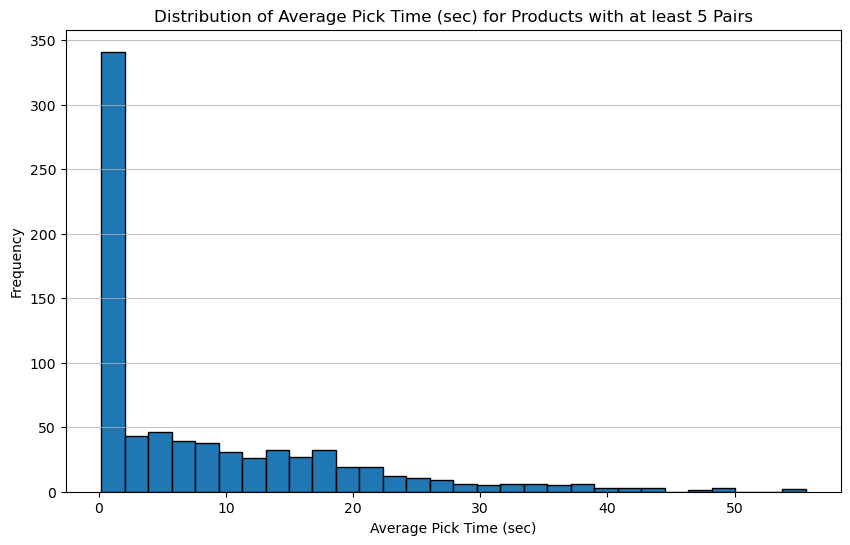

In [70]:
# PLot distribution of avg_pick_time_sec for products in product_pick_times with at least 5 pairs
plt.figure(figsize=(10, 6))
subset = product_pick_times[(product_pick_times["n_pairs"] >= 5) & 
                            (product_pick_times["avg_pick_time_sec"] > 0) & 
                            (product_pick_times["avg_pick_time_sec"] < 60)]
plt.hist(subset["avg_pick_time_sec"].dropna(), bins=30, edgecolor="k")
plt.title("Distribution of Average Pick Time (sec) for Products with at least 5 Pairs")
plt.xlabel("Average Pick Time (sec)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

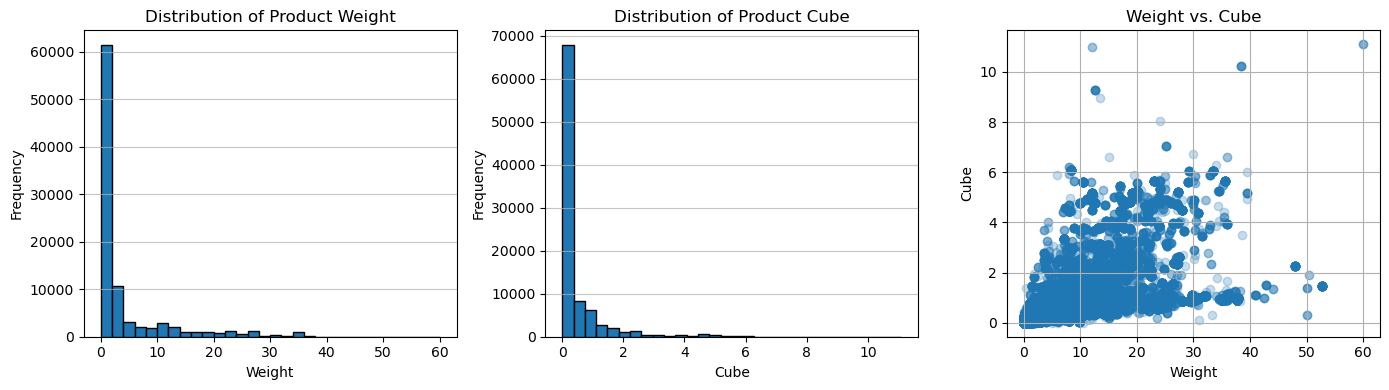

In [99]:
# Filter so weight and cude are not null or 0
filtered_OE_joined = OE_joined[
    (OE_joined["Weight"].notna()) & (OE_joined["Weight"] > 0) &
    (OE_joined["Cube"].notna()) & (OE_joined["Cube"] > 0)
].copy()
# Plot distribution of weight and cube side by side in OE_joined
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.hist(filtered_OE_joined["Weight"].dropna(), bins=30, edgecolor="k")
plt.title("Distribution of Product Weight")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 3, 2)
plt.hist(filtered_OE_joined["Cube"].dropna(), bins=30, edgecolor="k")
plt.title("Distribution of Product Cube")
plt.xlabel("Cube")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 3, 3)
plt.scatter(filtered_OE_joined["Weight"], filtered_OE_joined["Cube"], alpha=0.25)
plt.title("Weight vs. Cube")
plt.xlabel("Weight")
plt.ylabel("Cube")
plt.grid()
plt.tight_layout()
plt.show()

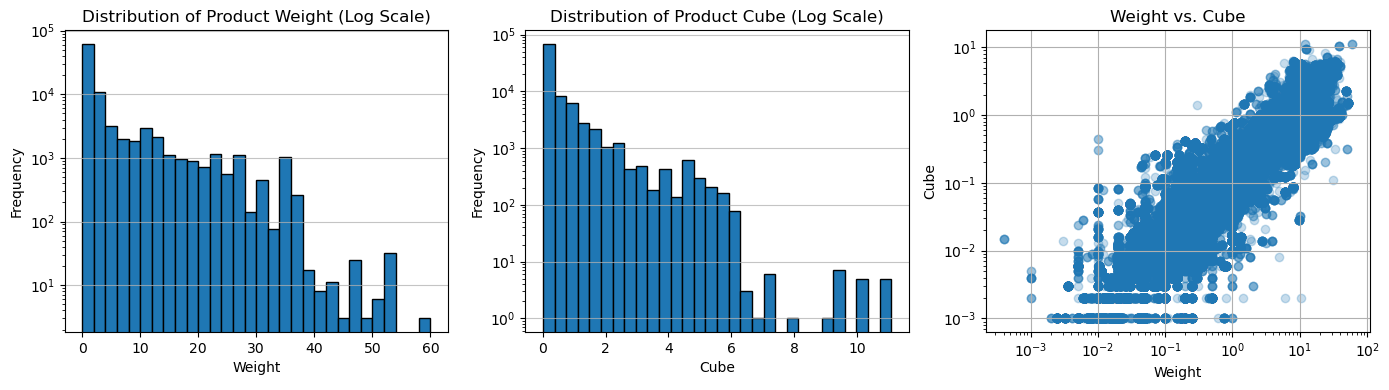

In [100]:
# Same plots oas in the rpevious chunk, but all on log scale
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.hist(filtered_OE_joined["Weight"].dropna(), bins=30, edgecolor="k")
plt.title("Distribution of Product Weight (Log Scale)")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 3, 2)
plt.hist(filtered_OE_joined["Cube"].dropna(), bins=30, edgecolor="k")
plt.title("Distribution of Product Cube (Log Scale)")
plt.xlabel("Cube")
plt.ylabel("Frequency") 
plt.yscale("log")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 3, 3)
plt.scatter(filtered_OE_joined["Weight"], filtered_OE_joined["Cube"], alpha=0.25)
plt.title("Weight vs. Cube")
plt.xlabel("Weight")
plt.ylabel("Cube")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.tight_layout()
plt.show()

In [101]:
# Compute correlation between weight and cube in filtered_OE_joined, normal scale and on log scale
correlation_normal = filtered_OE_joined[["Weight", "Cube"]].corr().loc["Weight", "Cube"]
correlation_log = np.log(filtered_OE_joined[["Weight", "Cube"]]).corr().loc["Weight", "Cube"]
print(f"Correlation between Weight and Cube (Normal Scale): {correlation_normal:.4f}")
print(f"Correlation between Weight and Cube (Log Scale): {correlation_log:.4f}")

Correlation between Weight and Cube (Normal Scale): 0.6570
Correlation between Weight and Cube (Log Scale): 0.8923


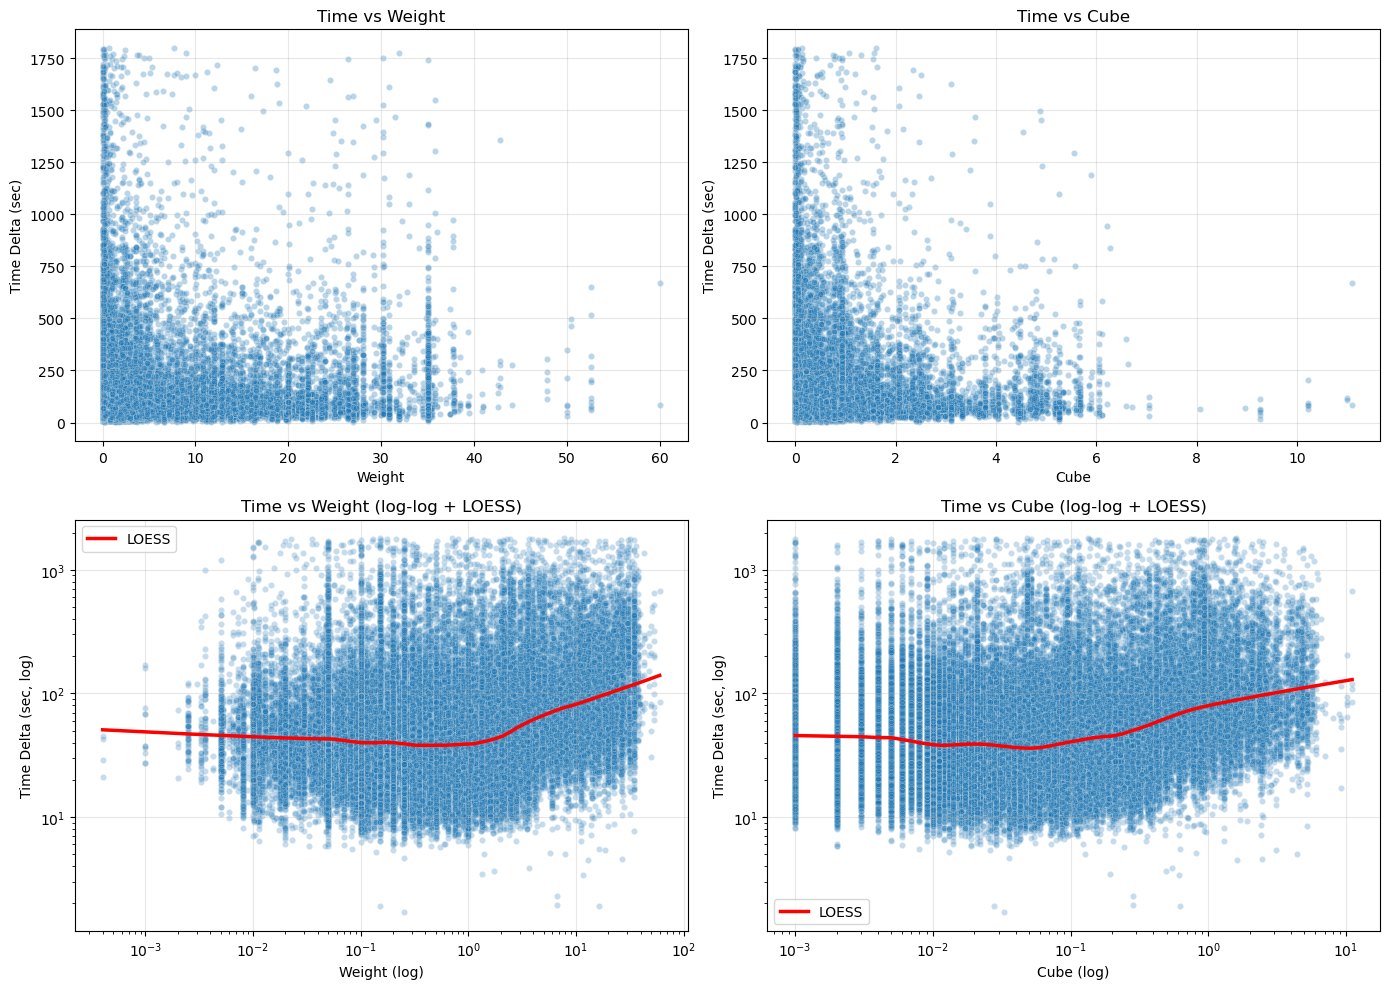

In [107]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plot_df = OE_joined[
    (OE_joined["LocationID"] != OE_joined["Prev_LocationID"]) &
    (OE_joined["Time_Delta_sec"] > 0) &
    OE_joined["Weight"].notna() &
    OE_joined["Cube"].notna()
].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------- Linear scales --------

sns.scatterplot(
    data=plot_df,
    x="Weight",
    y="Time_Delta_sec",
    alpha=0.3,
    s=20,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Time vs Weight")
axes[0, 0].set_xlabel("Weight")
axes[0, 0].set_ylabel("Time Delta (sec)")

sns.scatterplot(
    data=plot_df,
    x="Cube",
    y="Time_Delta_sec",
    alpha=0.3,
    s=20,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Time vs Cube")
axes[0, 1].set_xlabel("Cube")
axes[0, 1].set_ylabel("Time Delta (sec)")

# -------- Log–Log scales with LOESS --------

log_df = plot_df[
    (plot_df["Weight"] > 0) &
    (plot_df["Cube"] > 0)
].copy()

# --- Weight log-log plot ---
sns.scatterplot(
    data=log_df,
    x="Weight",
    y="Time_Delta_sec",
    alpha=0.25,
    s=20,
    ax=axes[1, 0]
)

# LOWESS in log-log space
x = log_df["Weight"].values
y = log_df["Time_Delta_sec"].values

smoothed = lowess(np.log(y), np.log(x), frac=0.25)
xs = np.exp(smoothed[:, 0])
ys = np.exp(smoothed[:, 1])

axes[1, 0].plot(xs, ys, color="red", linewidth=2.5, label="LOESS")

axes[1, 0].set_xscale("log")
axes[1, 0].set_yscale("log")
axes[1, 0].set_title("Time vs Weight (log-log + LOESS)")
axes[1, 0].set_xlabel("Weight (log)")
axes[1, 0].set_ylabel("Time Delta (sec, log)")
axes[1, 0].legend()

# --- Cube log-log plot ---
sns.scatterplot(
    data=log_df,
    x="Cube",
    y="Time_Delta_sec",
    alpha=0.25,
    s=20,
    ax=axes[1, 1]
)

x2 = log_df["Cube"].values
y2 = log_df["Time_Delta_sec"].values

smoothed2 = lowess(np.log(y2), np.log(x2), frac=0.25)
xs2 = np.exp(smoothed2[:, 0])
ys2 = np.exp(smoothed2[:, 1])

axes[1, 1].plot(xs2, ys2, color="red", linewidth=2.5, label="LOESS")

axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_title("Time vs Cube (log-log + LOESS)")
axes[1, 1].set_xlabel("Cube (log)")
axes[1, 1].set_ylabel("Time Delta (sec, log)")
axes[1, 1].legend()

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

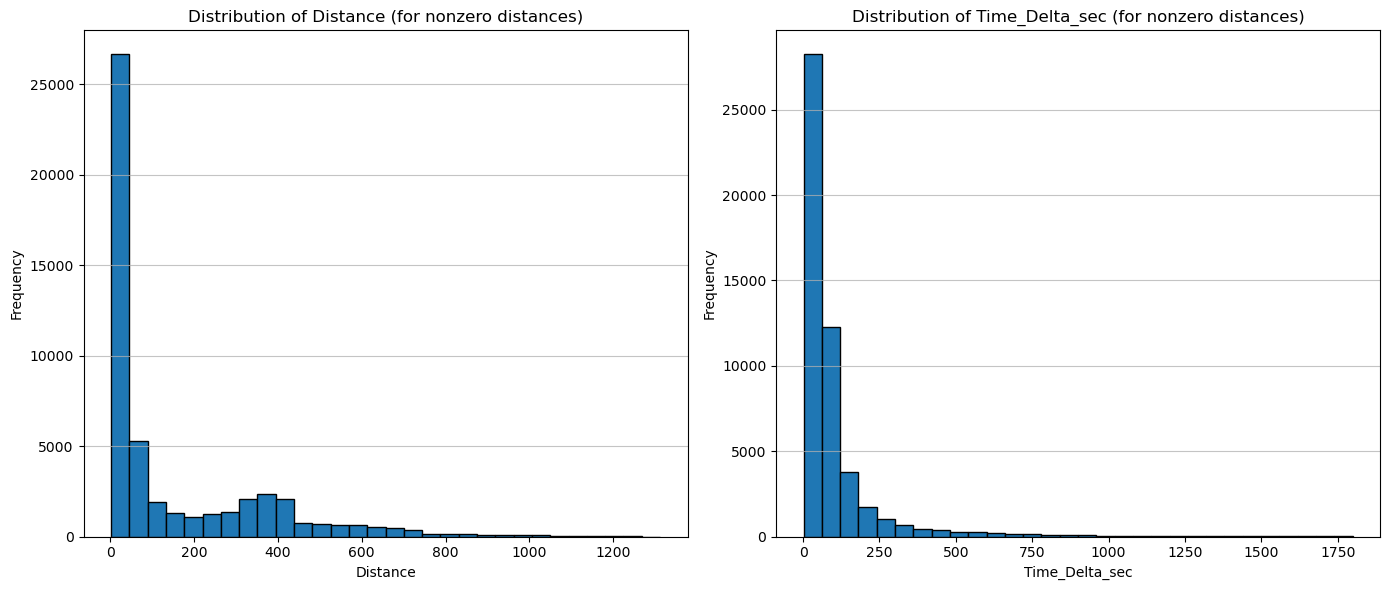

In [72]:
# Plot distributions of Distance and Time_Delta_sec side by side in OE_detailed
# For rows with Distance != 0 only 
subset = OE_detailed[(OE_detailed["Distance"].notna()) & (OE_detailed["Distance"] != 0) & (OE_detailed["Time_Delta_sec"].notna())]
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(subset["Distance"], bins=30, edgecolor="k")
plt.title("Distribution of Distance (for nonzero distances)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 2, 2)
plt.hist(subset["Time_Delta_sec"], bins=30, edgecolor="k")
plt.title("Distribution of Time_Delta_sec (for nonzero distances)")
plt.xlabel("Time_Delta_sec")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

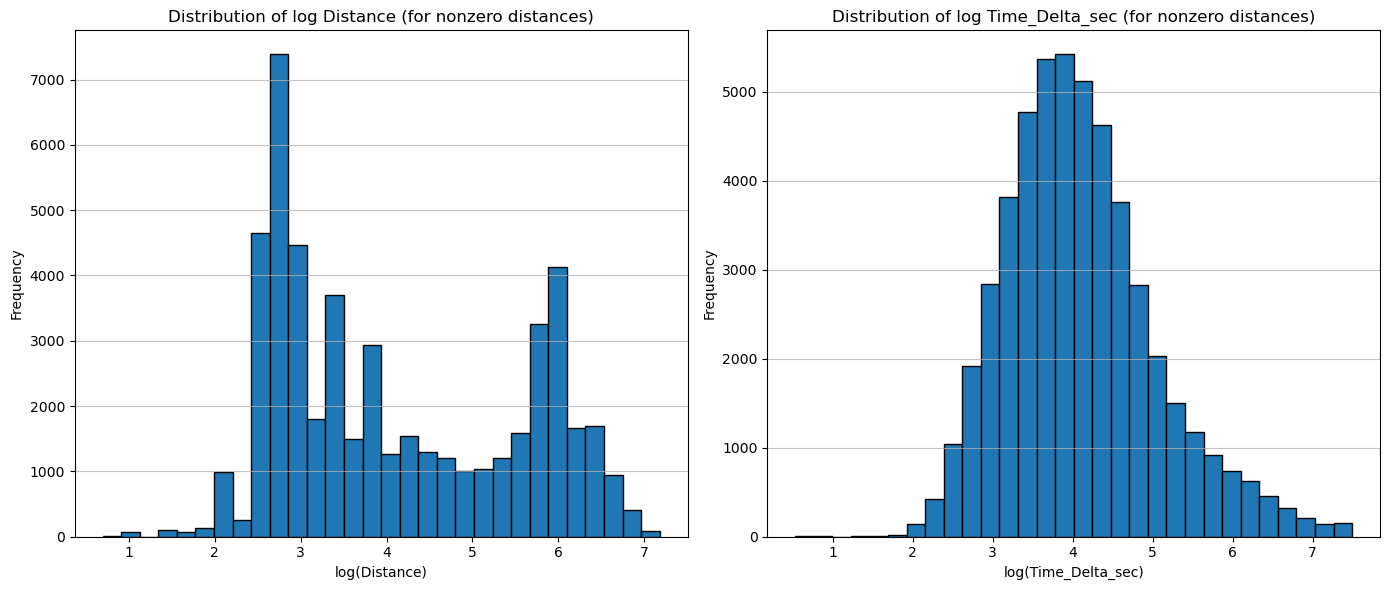

In [73]:
# Plot distributions of log Distance and log Time_Delta_sec side by side in OE_detailed
# For rows with Distance != 0 only 
subset = OE_detailed[(OE_detailed["Distance"].notna()) & (OE_detailed["Distance"] != 0) & (OE_detailed["Time_Delta_sec"].notna()) & (OE_detailed["Time_Delta_sec"] > 0)]
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(np.log(subset["Distance"]), bins=30, edgecolor="k")
plt.title("Distribution of log Distance (for nonzero distances)")
plt.xlabel("log(Distance)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.subplot(1, 2, 2)
plt.hist(np.log(subset["Time_Delta_sec"]), bins=30, edgecolor="k")
plt.title("Distribution of log Time_Delta_sec (for nonzero distances)")
plt.xlabel("log(Time_Delta_sec)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

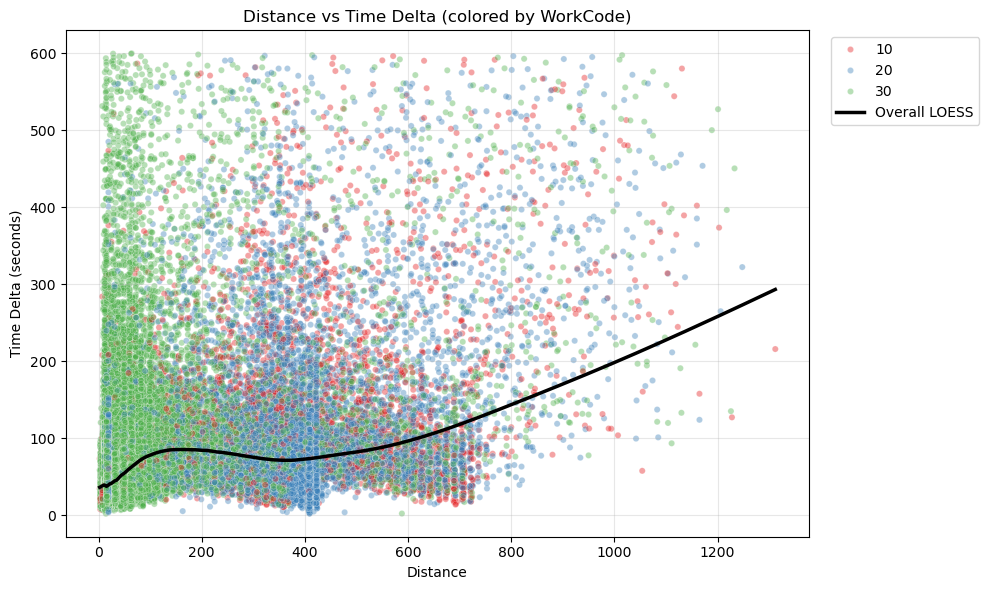

In [74]:
# In OE_detailed, plot scatter of Distance vs Time_Delta_sec colored by WorkCode
# Filter out rows with distance == 0
# Add a LOESS line or moving average line to show overall trend
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

# Prepare filtered dataset
plot_df = OE_detailed[
    (OE_detailed["Distance"] > 0) &
    (OE_detailed["Time_Delta_sec"] > 0) &
    (OE_detailed["Time_Delta_sec"] < 600)   # optional window
].copy()

plt.figure(figsize=(10, 6))

# Scatter colored by WorkCode
sns.scatterplot(
    data=plot_df,
    x="Distance",
    y="Time_Delta_sec",
    hue="WorkCode",
    alpha=0.4,
    s=20,
    palette="Set1"
)

x = plot_df["Distance"].values
y = plot_df["Time_Delta_sec"].values
# Compute LOWESS smooth
smoothed = lowess(y, x, frac=0.25)   # frac controls smoothness
xs, ys = smoothed[:, 0], smoothed[:, 1]

plt.plot(xs, ys, color="black", linewidth=2.5, label="Overall LOESS")
plt.title("Distance vs Time Delta (colored by WorkCode)")
plt.xlabel("Distance")
plt.ylabel("Time Delta (seconds)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

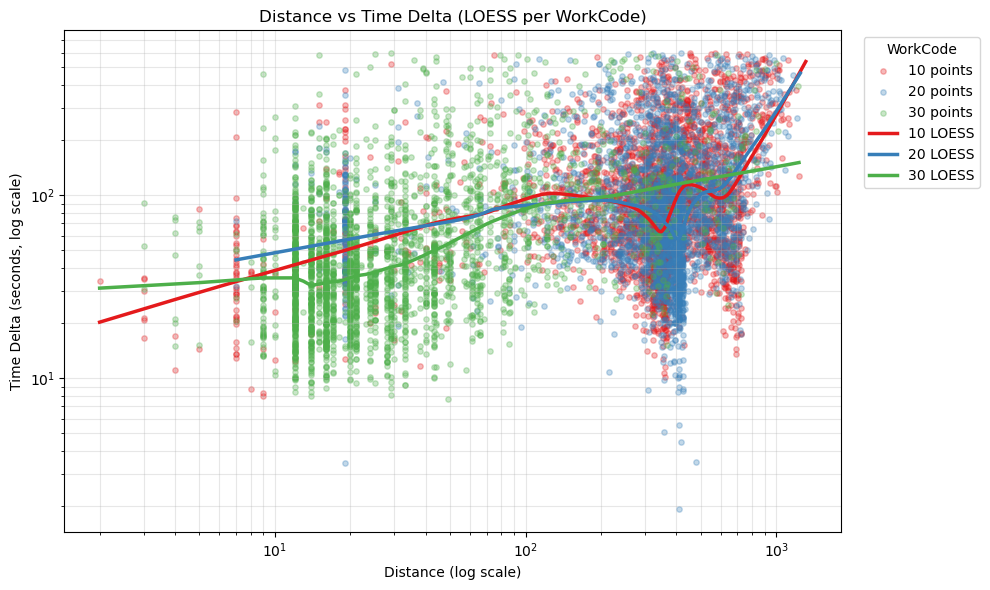

In [ ]:
plot_df["WorkCode"] = plot_df["WorkCode"].astype(str)

plt.figure(figsize=(10, 6))

# Distinct palette
workcodes = sorted(plot_df["WorkCode"].unique())
palette = sns.color_palette("Set1", n_colors=len(workcodes))
color_map = dict(zip(workcodes, palette))

# ---- Scatter (subsampled for clarity) ----
for wc in workcodes:
    sub = plot_df[plot_df["WorkCode"] == wc]
    
    if len(sub) > 3000:
        sub = sub.sample(n=3000, random_state=42)

    plt.scatter(
        sub["Distance"],
        sub["Time_Delta_sec"],
        alpha=0.3,
        s=15,
        color=color_map[wc],
        label=f"{wc} points"
    )

# ---- LOESS per WorkCode ----
for wc in workcodes:
    sub = plot_df[plot_df["WorkCode"] == wc]

    # Need enough points for smoothing
    if len(sub) < 50:
        continue

    x = sub["Distance"].values
    y = sub["Time_Delta_sec"].values

    # LOWESS in log-log space
    smoothed = lowess(np.log(y), np.log(x), frac=0.3)

    xs = np.exp(smoothed[:, 0])
    ys = np.exp(smoothed[:, 1])

    plt.plot(xs, ys,
             color=color_map[wc],
             linewidth=2.5,
             label=f"{wc} LOESS")

# ---- Formatting ----
plt.xscale("log")
plt.yscale("log")

plt.title("Distance vs Time Delta (LOESS per WorkCode)")
plt.xlabel("Distance (log scale)")
plt.ylabel("Time Delta (seconds, log scale)")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="WorkCode")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

In [118]:
df = OE_joined.copy()
df = df.sort_values(["UserID", "Timestamp"]).reset_index(drop=True)

# Filter: consecutive tasks where (Aisle,Bay) same as previous, Level differs
mask = (
    df["Prev_Aisle"].notna() & df["Prev_Bay"].notna() &
    df["Aisle"].notna() & df["Bay"].notna() &
    (df["Aisle"] == df["Prev_Aisle"]) &
    (df["Bay"] == df["Prev_Bay"]) &
    df["Level"].notna() & df["Prev_Level"].notna() &
    (df["LocationID"] != df["Prev_LocationID"])
)

level_study = df.loc[mask].copy()

# Signed level delta (current - previous)
level_study["Level_Delta"] = (level_study["Level"] - level_study["Prev_Level"]).astype("Int64")

# Keep useful columns (Time_Delta_sec already exists; no recompute)
level_study = level_study[[
    "UserID", "Timestamp", "Prev_Timestamp",
    "Aisle", "Bay", "Prev_Aisle", "Prev_Bay",
    "Level", "Prev_Level", "Level_Delta",
    "Time_Delta_sec",
    "LocationID", "Prev_LocationID",
    "ProductID", "WorkCode"
]]

level_study.head()

,UserID,Timestamp,Prev_Timestamp,Aisle,Bay,Prev_Aisle,Prev_Bay,Level,Prev_Level,Level_Delta,Time_Delta_sec,LocationID,Prev_LocationID,ProductID,WorkCode
5,64,2025-11-10 12:36:48.807,2025-11-10 12:36:27.187,41,6,41,6,6,3,3,21.620,29361,818,202,20
13,64,2025-11-10 12:57:19.747,2025-11-10 12:56:45.757,36,36,36,36,3,3,0,33.990,5317,54443,39836,10
20,64,2025-11-10 13:05:06.140,2025-11-10 13:04:37.983,36,36,36,36,3,3,0,28.157,5317,54443,39836,10
77,64,2025-11-10 16:19:08.530,2025-11-10 16:10:10.170,18,12,18,12,4,1,3,538.360,56364,19305,3659,10
105,64,2025-11-10 18:13:30.580,2025-11-10 18:12:31.780,42,4,42,4,7,7,0,58.800,111918,18192,8020,10


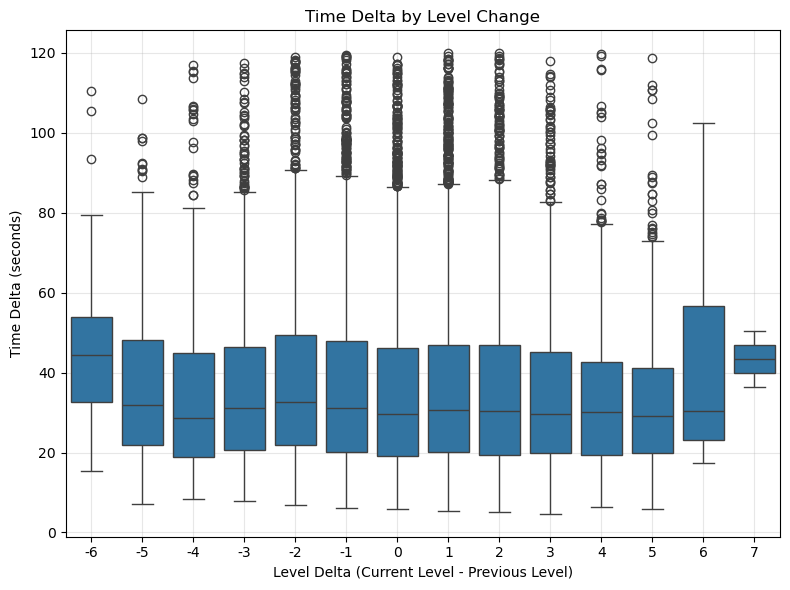

In [120]:
# Plot level delta vs time delta boxplot, for time delta less than 120s
plt.figure(figsize=(8, 6))
sns.boxplot(data=level_study[level_study["Time_Delta_sec"] < 120], x="Level_Delta", y="Time_Delta_sec")
plt.title("Time Delta by Level Change")
plt.xlabel("Level Delta (Current Level - Previous Level)")
plt.ylabel("Time Delta (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()